# 필요 package import

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier

# Version

### 개발 OS 
- windows 11

In [2]:
# python version
import sys
sys.version

'3.11.3 | packaged by Anaconda, Inc. | (main, Apr 19 2023, 23:46:34) [MSC v.1916 64 bit (AMD64)]'

In [4]:
# 사용 모델 version
import catboost
import sklearn

print("Catboost version :", catboost.__version__)
print("sklearn version :", sklearn.__version__)

Catboost version : 1.2.7
sklearn version : 1.2.2


### 데이터셋 불러오기

In [5]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Data Prepocessing

### 13개의 새로운 피처 추가

In [6]:
# 'balance' 컬럼에 로그 변환 적용
train_data['balance_log'] = np.log1p(train_data['balance'])
test_data['balance_log'] = np.log1p(test_data['balance'])

# 첫 번째 연락 여부
train_data['is_first_contact'] = (train_data['pdays'] == -1).astype(int)
test_data['is_first_contact'] = (test_data['pdays'] == -1).astype(int)

# 이전 캠페인 성공 여부
train_data['is_success_previous'] = (train_data['poutcome'] == 'success').astype(int)
test_data['is_success_previous'] = (test_data['poutcome'] == 'success').astype(int)

# 잔고 대비 대출 비율
train_data['balance_to_loan_ratio'] = train_data['balance'] / (1 + (train_data['loan'] == 'yes').astype(int))
test_data['balance_to_loan_ratio'] = test_data['balance'] / (1 + (test_data['loan'] == 'yes').astype(int))

# 잔고가 높은지 여부 플래그 (balance > 5000)
train_data['high_balance_flag'] = (train_data['balance'] > 5000).astype(int)
test_data['high_balance_flag'] = (test_data['balance'] > 5000).astype(int)

# 전화기로 연락했는지 여부
train_data['is_telephone_contact'] = (train_data['contact'] == 'telephone').astype(int)
test_data['is_telephone_contact'] = (test_data['contact'] == 'telephone').astype(int)

# 캠페인당 평균 통화 시간
train_data['contact_duration_per_call'] = train_data['duration'] / (train_data['campaign'] + 1)
test_data['contact_duration_per_call'] = test_data['duration'] / (test_data['campaign'] + 1)

# 성수기(5월, 8월)에 연락했는지 여부
peak_months = ['may', 'aug']
train_data['is_contact_in_peak_months'] = train_data['month'].isin(peak_months).astype(int)
test_data['is_contact_in_peak_months'] = test_data['month'].isin(peak_months).astype(int)

# 분기 데이터
def map_to_quarter(month):
    if month in ['jan', 'feb', 'mar']:
        return 1
    elif month in ['apr', 'may', 'jun']:
        return 2
    elif month in ['jul', 'aug', 'sep']:
        return 3
    elif month in ['oct', 'nov', 'dec']:
        return 4

train_data['quarter'] = train_data['month'].apply(map_to_quarter)
test_data['quarter'] = test_data['month'].apply(map_to_quarter)

# 연령대 그룹화
def categorize_age(age):
    if age < 20:
        return '10대 미만'
    elif 20 <= age < 30:
        return '20대'
    elif 30 <= age < 40:
        return '30대'
    elif 40 <= age < 50:
        return '40대'
    elif 50 <= age < 60:
        return '50대'
    elif 60 <= age < 70:
        return '60대'
    else:
        return '70대 이상'

train_data['age_group'] = train_data['age'].apply(categorize_age)
test_data['age_group'] = test_data['age'].apply(categorize_age)

# 캠페인 횟수 대비 통화 시간 비율
train_data['campaign_per_duration'] = train_data['campaign'] / (train_data['duration'] + 1)
test_data['campaign_per_duration'] = test_data['campaign'] / (test_data['duration'] + 1)

# 나이가 30 이하인지 여부
train_data['is_young'] = (train_data['age'] <= 30).astype(int)
test_data['is_young'] = (test_data['age'] <= 30).astype(int)


C:\Users\82108\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\82108\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\82108\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\82108\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


## inf값 및 결측값 처리
- balance에 로그변환을 취해 발생한 무한값을 결측값으로 변환
- 수치형 변수는 평균값으로, 범주형 변수는 최빈값으로 결측값 대체 

In [7]:
train_data.replace([np.inf, -np.inf], np.nan, inplace=True)
test_data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [8]:
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome',
    'quarter', 'age_group']
numerical_cols = ['age', 'balance', 'balance_log', 'duration', 'campaign']
for col in numerical_cols:
    train_data[col] = train_data[col].fillna(train_data[col].mean())
    test_data[col] = test_data[col].fillna(test_data[col].mean())

for col in categorical_cols:
    train_data[col] = train_data[col].fillna(train_data[col].mode()[0])
    test_data[col] = test_data[col].fillna(test_data[col].mode()[0])
print(train_data.isnull().sum())
print(test_data.isnull().sum())

ID                           0
age                          0
job                          0
marital                      0
education                    0
default                      0
balance                      0
housing                      0
loan                         0
contact                      0
day                          0
month                        0
duration                     0
campaign                     0
pdays                        0
previous                     0
poutcome                     0
label                        0
balance_log                  0
is_first_contact             0
is_success_previous          0
balance_to_loan_ratio        0
high_balance_flag            0
is_telephone_contact         0
contact_duration_per_call    0
is_contact_in_peak_months    0
quarter                      0
age_group                    0
campaign_per_duration        0
is_young                     0
dtype: int64
ID                               0
age                   

## 전처리 확인

In [9]:
train_data

,ID,age,job,marital,education,default,balance,housing,loan,contact,...,is_success_previous,balance_to_loan_ratio,high_balance_flag,is_telephone_contact,contact_duration_per_call,is_contact_in_peak_months,quarter,age_group,campaign_per_duration,is_young
0,train00001,34,blue-collar,married,primary,no,358,yes,no,unknown,...,0,358.0,0,0,20.000000,1,2,30대,0.039604,0
1,train00002,33,blue-collar,married,secondary,no,-53,yes,no,unknown,...,0,-53.0,0,0,86.000000,1,2,30대,0.005780,0
2,train00003,32,management,single,tertiary,no,207,yes,no,cellular,...,0,207.0,0,0,28.000000,0,1,30대,0.017544,0
3,train00004,37,blue-collar,divorced,secondary,no,638,yes,no,cellular,...,1,638.0,0,0,163.000000,1,2,30대,0.003058,0
4,train00005,33,housemaid,married,secondary,no,826,yes,no,cellular,...,0,826.0,0,0,128.000000,1,2,30대,0.003891,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31642,train31643,60,retired,married,secondary,no,3932,yes,no,unknown,...,0,3932.0,0,0,135.666667,1,2,60대,0.004902,0
31643,train31644,44,blue-collar,married,unknown,no,15578,yes,no,unknown,...,0,15578.0,1,0,200.500000,1,2,40대,0.002488,0
31644,train31645,54,unemployed,single,secondary,no,3611,yes,no,cellular,...,0,3611.0,0,0,40.500000,0,1,50대,0.012195,0
31645,train31646,33,services,married,secondary,yes,2,no,no,cellular,...,0,2.0,0,0,22.666667,1,2,30대,0.036496,0


In [10]:
test_data

,ID,age,job,marital,education,default,balance,housing,loan,contact,...,is_success_previous,balance_to_loan_ratio,high_balance_flag,is_telephone_contact,contact_duration_per_call,is_contact_in_peak_months,quarter,age_group,campaign_per_duration,is_young
0,test00001,54,management,divorced,tertiary,no,6410,no,no,cellular,...,0,6410.0,1,0,33.666667,0,4,50대,0.019608,0
1,test00002,56,unemployed,divorced,primary,no,282,no,no,cellular,...,0,282.0,0,0,52.000000,0,1,50대,0.012739,0
2,test00003,34,management,married,secondary,no,355,no,no,cellular,...,0,355.0,0,0,78.500000,1,3,30대,0.009524,0
3,test00004,55,management,married,tertiary,no,568,no,no,cellular,...,0,568.0,0,0,85.454545,1,3,50대,0.010627,0
4,test00005,38,technician,married,secondary,no,6728,no,no,cellular,...,0,6728.0,1,0,50.400000,1,3,30대,0.015810,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13559,test13560,32,management,single,tertiary,no,19985,no,no,cellular,...,0,19985.0,1,0,102.666667,0,1,30대,0.008104,0
13560,test13561,31,student,single,tertiary,no,307,no,no,cellular,...,0,307.0,0,0,199.000000,0,4,30대,0.003344,0
13561,test13562,38,blue-collar,married,secondary,no,20,yes,no,unknown,...,0,20.0,0,0,201.000000,1,2,30대,0.002481,0
13562,test13563,26,management,single,tertiary,no,3,yes,no,cellular,...,0,3.0,0,0,53.000000,0,3,20대,0.009346,1


# Encoding
- Label Encoder

In [11]:
label_encoders = {}
for col in categorical_cols:
   le = LabelEncoder()
   train_data[col] = le.fit_transform(train_data[col])
   test_data[col] = le.transform(test_data[col])
   label_encoders[col] = le

# Modeling
- CatBoostClassifier
- Cross-validation (fold=5, StratifiedKFold)

In [12]:
train_data = train_data.drop(columns=['ID'])
test_data = test_data.drop(columns=['ID'])

In [13]:
X = train_data.drop(columns=['label'])
y = train_data['label']

test_features = test_data.drop(columns=['label'])

In [23]:
# Modeling - CatBoost with Stratified K-Fold
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
import numpy as np

# CatBoost hyperparameters
params = {
    'iterations': 10000,
    'learning_rate': 0.04,
    'depth': 4,
    'eval_metric': 'F1',
    'verbose': 1000,
    'random_seed': 42
}

# K-Fold setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_scores = []  # F1 점수 저장
validation_predictions = np.zeros(len(X))  # 검증 데이터 예측 확률 저장
oof_predictions = np.zeros(len(test_features))  # 테스트 데이터 OOF 예측 확률 저장

for fold, (train_idx, valid_idx) in enumerate(kf.split(X, y)):
    print(f"Fold {fold + 1}")

    # Train/Validation split
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # CatBoost 모델 학습
    model = CatBoostClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=(X_valid, y_valid),
        early_stopping_rounds=1000,
        use_best_model=True
    )

    # Validation 예측
    y_pred_proba = model.predict_proba(X_valid)[:, 1]
    validation_predictions[valid_idx] = y_pred_proba  # Fold별 검증 예측 확률 저장
    y_pred = (y_pred_proba > 0.3).astype(int)
    f1 = f1_score(y_valid, y_pred)
    f1_scores.append(f1)

    # Test 예측 및 OOF 저장
    oof_predictions += model.predict_proba(test_features)[:, 1] / kf.n_splits

# Modeling 결과 출력
print("F1 Scores for each fold:", f1_scores)
print("Mean F1 Score:", np.mean(f1_scores))


Fold 1
0:	learn: 0.2826202	test: 0.3020833	best: 0.3020833 (0)	total: 35.5ms	remaining: 5m 55s
1000:	learn: 0.6435093	test: 0.5446154	best: 0.5468510 (992)	total: 14.9s	remaining: 2m 13s
2000:	learn: 0.7202012	test: 0.5639098	best: 0.5679758 (1768)	total: 29.7s	remaining: 1m 58s
3000:	learn: 0.7682880	test: 0.5622189	best: 0.5690691 (2110)	total: 44.2s	remaining: 1m 43s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.5690690691
bestIteration = 2110

Shrink model to first 2111 iterations.
Fold 2
0:	learn: 0.4892588	test: 0.4773989	best: 0.4773989 (0)	total: 18.1ms	remaining: 3m
1000:	learn: 0.6428856	test: 0.5270816	best: 0.5270816 (1000)	total: 14.9s	remaining: 2m 13s
2000:	learn: 0.7188778	test: 0.5376685	best: 0.5404120 (1987)	total: 29.5s	remaining: 1m 57s
3000:	learn: 0.7762731	test: 0.5464481	best: 0.5505882 (2576)	total: 44.3s	remaining: 1m 43s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.5505882353
bestIteration = 2576

Shrink model

# Evaluation

Cross-Validation(5-Fold Stratified K-Fold) 결과:
- 각 Fold의 F1-Score: [0.6213821618428824, 0.6073805202661826, 0.6150091519219036, 0.6361386138613861, 0.6178073894609327]
- 평균 F1-Score: 0.6195435674706575

테스트 데이터 결과:
- F1-Score: 0.619


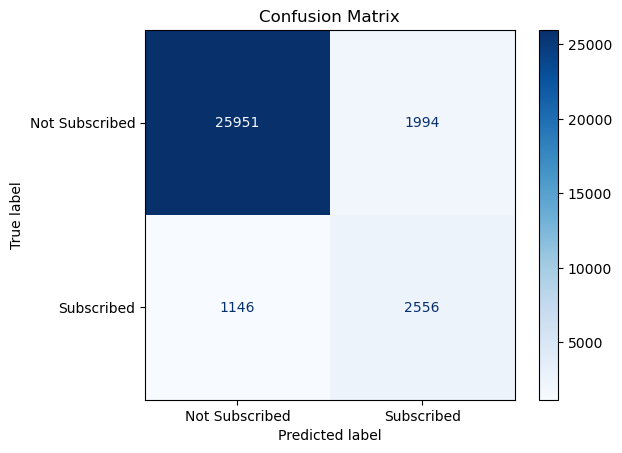

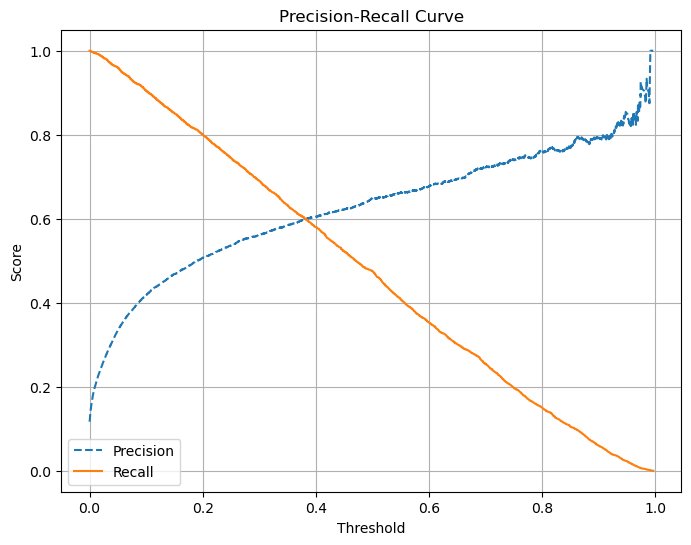

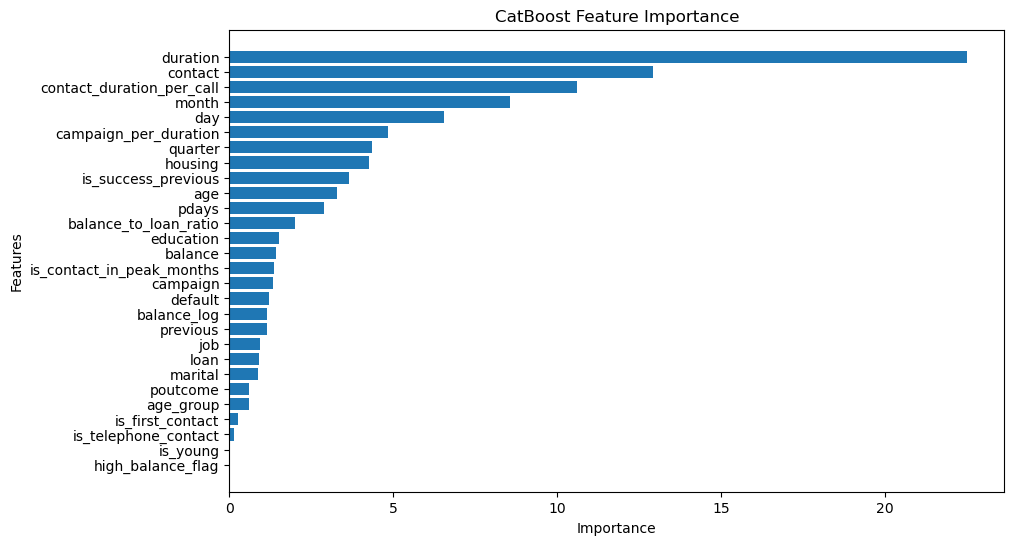

In [27]:
# F1 Score 요약
print(f"Cross-Validation(5-Fold Stratified K-Fold) 결과:")
print("- 각 Fold의 F1-Score:", f1_scores)
print("- 평균 F1-Score:", np.mean(f1_scores))

# 테스트 데이터 예측
valid_f1_score = f1_score(y, (validation_predictions > 0.3).astype(int))
print(f"\n테스트 데이터 결과:")
print(f"- F1-Score: {valid_f1_score:.3f}")

# 1. 혼동 행렬(Confusion Matrix)
cm = confusion_matrix(y, (validation_predictions > 0.3).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Subscribed", "Subscribed"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# 2. Precision-Recall Curve
precisions, recalls, thresholds = precision_recall_curve(y, validation_predictions)
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], label='Precision', linestyle='--')
plt.plot(thresholds, recalls[:-1], label='Recall', linestyle='-')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

# 3. Feature Importance
cat_features = X.columns
cat_importances = model.get_feature_importance()
cat_importances_df = pd.DataFrame({
    'Feature': cat_features,
    'Importance': cat_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(cat_importances_df['Feature'], cat_importances_df['Importance'])
plt.gca().invert_yaxis() 
plt.title("CatBoost Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

# Submission

In [16]:
predictions = []
for prob in oof_predictions:
    if prob > 0.3:
        predictions.append(1)  # Positive
    else:
        predictions.append(0)  # Negative


In [17]:
submission = pd.read_csv('./submission_example.csv')
submission['label'] = predictions

In [18]:
submission.to_csv('sub_catboost.csv', index = False)